### Installing Necessary Packages

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=84940a7ff70d50bf7e56f64156d59a675b1ec33316c1f8b72c29e79c515538cc
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


### Necessary Packages

In [ ]:
import torch
import os
import numpy as np
import tempfile
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors
from torch import nn
from torchvision.models import resnet18,ResNet18_Weights
from torch.utils.data import Dataset,DataLoader
from pyspark.sql import SparkSession,DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH
from typing import Optional,Callable,Any
from PIL import Image
from tqdm.notebook import tqdm

### Setup the code to be device agnostic

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cpu


### Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Global

In [ ]:
DATA_DIR = './drive/MyDrive/bdt/tp5_data'
IMAGES_DIR = os.path.join(DATA_DIR, 'cars_train')
CSV_IN_PATH = os.path.join(DATA_DIR, 'cars_train_data.csv')
EMBEDDINGS_CSV_DIR = os.path.join(DATA_DIR, 'embeddings')
BATCH_SIZE = 8
RANDOM_IMAGE_PATH = os.path.join(DATA_DIR, 'random_image.jpg')

### Spark setup

In [ ]:
spark = SparkSession.builder.getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


### Question 01 : transfrom the images using pytorch to be processible by `ResNet18`

- this code snipped only creates the transfrom and doesn't transfrom the images immediately,the transfromation is applied along the calculations of the embeddings.

In [ ]:
transfrom = ResNet18_Weights.IMAGENET1K_V1.transforms()

### Question 02 : Create a pytorch class that extracts an embeddings vector from a preprocessed image

In [ ]:
class ResNet18Extractor(nn.Module):

  def __init__(self):

    super().__init__()

    self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    self.model.fc = nn.Identity()

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    return self.model(x)

### Question 03 : calculate the image embeddings

In [ ]:
class ImageDirectory(Dataset):

  def __init__(self,
    root : str,
    transfrom : Optional[Callable]
  ) -> None:
    self.root = root
    self.transfrom = transfrom
    self.paths = self._find_images()

  def _find_images(self):
    images = os.listdir(self.root)
    paths = list(map(lambda x : os.path.join(self.root, x),images))
    return paths

  def __getitem__(self, index : int) -> Any:

    path = self.paths[index]
    img = Image.open(path)

    if self.transfrom is not None:
      img = self.transfrom(img)

    return path,img

  def __len__(self) -> int:
    return len(self.paths)

In [ ]:
dataset = ImageDirectory(root=IMAGES_DIR,transfrom=transfrom)

In [ ]:
loader = DataLoader(dataset=dataset,batch_size=BATCH_SIZE)

In [ ]:
print(len(dataset))
print(len(loader))

100
13


In [ ]:
def get_embeddings(
    lodaer : DataLoader,
    device : torch.device
) -> dict[str, np.ndarray]:

  result = {}

  model = ResNet18Extractor() \
    .to(device) \
    .eval()

  with torch.inference_mode():

    for paths,images in tqdm(loader):
      images = images.to(device)
      embeddings = model(images).cpu()

      for path,embedding in zip(paths,embeddings):
        basename = os.path.basename(path)
        result[basename] = embedding.numpy()

  return result

In [ ]:
embeddings = get_embeddings(loader, device)

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
embeddings[next(iter(embeddings.keys()))].shape

(512,)

### Question 04 : Save the embeddings in a csv file

In [ ]:
df = spark.read.csv(CSV_IN_PATH,header=True,inferSchema=True)
df.show()

+---+---+---+----+----+-----+---------+
|_c0| x1| y1|  x2|  y2|Class|    image|
+---+---+---+----+----+-----+---------+
|  0| 39|116| 569| 375|   14|00001.jpg|
|  1| 36|116| 868| 587|    3|00002.jpg|
|  2| 85|109| 601| 381|   91|00003.jpg|
|  3|621|393|1484|1096|  134|00004.jpg|
|  4| 14| 36| 133|  99|  106|00005.jpg|
|  5|259|289| 515| 416|  123|00006.jpg|
|  6| 88| 80| 541| 397|   89|00007.jpg|
|  7| 73| 79| 591| 410|   96|00008.jpg|
|  8| 20|126|1269| 771|  167|00009.jpg|
|  9| 21|110| 623| 367|   58|00010.jpg|
| 10| 51| 93| 601| 393|   49|00011.jpg|
| 11|  6| 62| 499| 286|  186|00012.jpg|
| 12| 30| 36| 418| 307|  135|00013.jpg|
| 13| 31|246| 778| 540|   85|00014.jpg|
| 14| 32| 77| 589| 379|  193|00015.jpg|
| 15| 27| 49| 611| 396|  172|00016.jpg|
| 16| 39| 52| 233| 150|   14|00017.jpg|
| 17|  3|  8| 190| 147|   73|00018.jpg|
| 18|247|287|1366| 761|  192|00019.jpg|
| 19| 17|281| 961| 596|   57|00020.jpg|
+---+---+---+----+----+-----+---------+
only showing top 20 rows



In [ ]:
def create_df(embeddings : dict[str, np.ndarray], metadata_df : DataFrame, spark : SparkSession) -> DataFrame:

  rows = []

  for img,embedding in tqdm(embeddings.items()):

    class_ = metadata_df \
      .select(metadata_df.Class) \
      .where(metadata_df.image == img) \
      .first().Class

    row = tuple(embedding.tolist()) + (img,class_)
    rows.append(row)

  cols = [f'x{i}' for i in range(len(rows[0]) - 2)] + ['image','class']

  df = spark.createDataFrame(rows, cols)

  return df


In [ ]:
embeddings_df = create_df(embeddings, df, spark)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
embeddings_df.show(n=5)

+------------------+------------------+------------------+--------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+--------------------+--------------------+-----

### Question 04 : save the resulted data frame to a csv file

In [ ]:
embeddings_df \
    .coalesce(1) \
    .write.format("com.databricks.spark.csv") \
    .option("header", "true") \
    .mode('overwrite') \
    .save(EMBEDDINGS_CSV_DIR)

### Question 05 : Create a dataframe that contains the embeddings

In [ ]:
def load(dir : str,spark : SparkSession) -> DataFrame:
  name = next(iter(filter(lambda x : x.endswith('.csv'), os.listdir(dir))))
  path = os.path.join(dir, name)
  return spark.read.csv(path,header=True,inferSchema=True)

In [ ]:
embeddings_df = load(EMBEDDINGS_CSV_DIR, spark=spark)

In [ ]:
embeddings_df.show(n=5)

+------------------+------------------+------------------+--------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+--------------------+--------------------+-----

In [ ]:
embeddings_df.count()

100

### Question 06 : Apply a transformation to create a `Vector` column

In [ ]:
assembler = VectorAssembler() \
  .setInputCols(embeddings_df.columns[:-2]) \
  .setOutputCol('vector')

In [ ]:
embeddings_df = assembler.transform(embeddings_df)

In [ ]:
embeddings_df.select(embeddings_df.vector).show(n=5)

+--------------------+
|              vector|
+--------------------+
|[0.86253696680068...|
|[0.96701627969741...|
|[3.44262790679931...|
|[1.72980856895446...|
|[1.74234604835510...|
+--------------------+
only showing top 5 rows



### Question 07 : create a `BucketedRandomProjection` model

In [ ]:
NUM_CLASSES = 10

In [ ]:
brp = BucketedRandomProjectionLSH() \
  .setBucketLength(10) \
  .setNumHashTables(NUM_CLASSES) \
  .setInputCol('vector') \
  .setOutputCol('hash')

In [ ]:
brp_model = brp.fit(embeddings_df)

In [ ]:
embeddings_df = brp_model.transform(embeddings_df)

In [ ]:
embeddings_df.select(embeddings_df.hash).show(n=5)

+--------------------+
|                hash|
+--------------------+
|[[0.0], [-1.0], [...|
|[[0.0], [-1.0], [...|
|[[0.0], [-1.0], [...|
|[[0.0], [0.0], [0...|
|[[0.0], [0.0], [0...|
+--------------------+
only showing top 5 rows



### Question 09 : Choose a random image

- This image is the 00103 image from same dataset :

In [ ]:
img = Image.open(RANDOM_IMAGE_PATH)

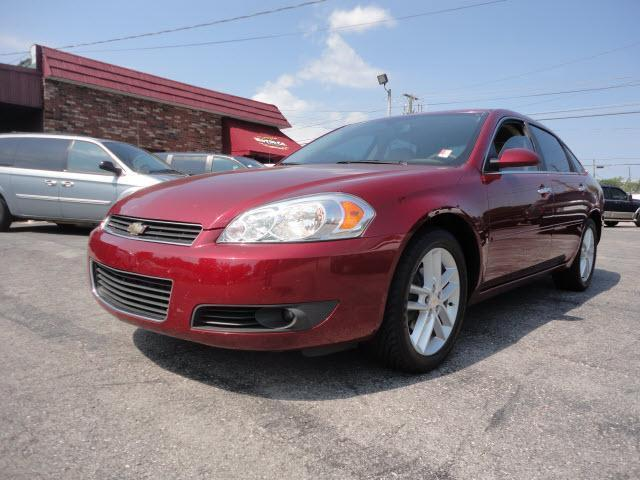

In [ ]:
img

### Question 10 : Calculate the embedding of this image

In [ ]:
transformed_img = transfrom(img).to(device)
embedding = None

In [ ]:
model = model = ResNet18Extractor() \
    .to(device) \
    .eval()

In [ ]:
with torch.inference_mode():
  embedding = model(torch.unsqueeze(transformed_img, dim=0))
  embedding = torch.squeeze(embedding).cpu()

In [ ]:
embedding.shape

torch.Size([512])

### Question 11 : Perform an approximative search with 5 neighrest neighbors

In [ ]:
key = Vectors.dense(*embedding)

In [ ]:
nearest_neighbors = brp_model.approxNearestNeighbors(dataset=embeddings_df, key=key, numNearestNeighbors=5)

In [ ]:
nearest_neighbors.show()

+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------

### Question 12 : Display the images that correspond to the five neighbors

In [ ]:
neighbors_names = [row.image for row in nearest_neighbors.select(nearest_neighbors.image).collect()]

In [ ]:
neighbors_names

['00085.jpg', '00016.jpg', '00026.jpg', '00072.jpg', '00082.jpg']

In [ ]:
def display_images(root : str, names : list[str]) -> None:

  fig, axes = plt.subplots(ncols=len(names),nrows=1)

  fig.set_size_inches(15,8)

  for name,ax in zip(names,axes):
    img_path = os.path.join(root, name)
    img = Image.open(img_path)
    ax.imshow(img)

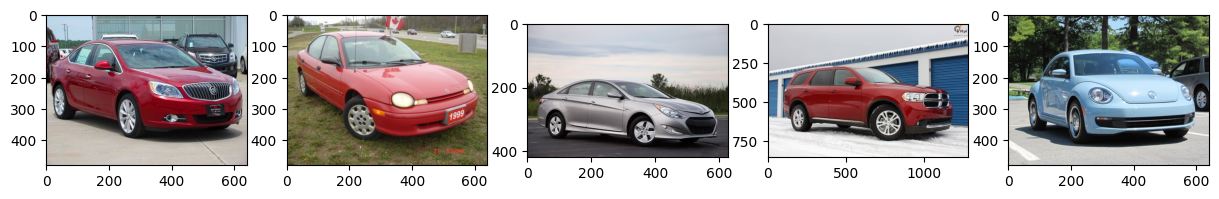

In [ ]:
display_images(IMAGES_DIR, neighbors_names)